# Preprocessing

## 0. Imports

In [1]:
# Core
import os
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image processing
import cv2
from PIL import Image

# Machine learning / deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Utility
import zipfile
import shutil
import pathlib

2025-10-24 13:58:01.112466: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-24 13:58:01.115682: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-24 13:58:01.134413: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-24 13:58:01.182801: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-24 13:58:01.275320: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registe

## 1. Data Loading from Kaggle

In [2]:
!pwd

/home/kieren/code/KierenElijaSchmidt/cs_project/notebooks/exploration


In [3]:
!pip install kaggle --quiet

In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls -l ~/.kaggle

mv: cannot stat 'kaggle.json': No such file or directory
total 4
-rw------- 1 kieren kieren 74 Oct 24 10:50 kaggle.json


In [5]:
!kaggle datasets list -s "brain tumor"

ref                                                       title                                                    size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  -------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
jakeshbohaju/brain-tumor                                  Brain Tumor                                          14629270  2020-07-26 01:52:35.323000          24390        323  0.9411765        
masoudnickparvar/brain-tumor-mri-dataset                  Brain Tumor MRI Dataset                             155791278  2021-09-24 12:43:45.510000         150504       1023  0.875            
sartajbhuvaji/brain-tumor-classification-mri              Brain Tumor Classification (MRI)                     91002358  2025-08-12 15:45:16.840000          88882        788  0.875            
jillanisofttech/brain-tumor        

In [6]:
!mkdir -p ../../data
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset -p ../../data


Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 71%|████████████████████████████▎           | 105M/149M [00:00<00:00, 1.10GB/s]
100%|████████████████████████████████████████| 149M/149M [00:00<00:00, 1.10GB/s]


In [7]:
import zipfile, os

zip_path = "../../data/brain-tumor-mri-dataset.zip"
extract_path = "../../data/brain-tumor-mri-dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

os.remove(zip_path)
print("✅ Dataset extracted to:", extract_path)

✅ Dataset extracted to: ../../data/brain-tumor-mri-dataset


In [8]:
from pathlib import Path

root = Path("../../data/brain-tumor-mri-dataset")
for d in root.rglob("*"):
    if d.is_dir():
        print(d)

../../data/brain-tumor-mri-dataset/Training
../../data/brain-tumor-mri-dataset/Testing
../../data/brain-tumor-mri-dataset/Training/pituitary
../../data/brain-tumor-mri-dataset/Training/glioma
../../data/brain-tumor-mri-dataset/Training/notumor
../../data/brain-tumor-mri-dataset/Training/meningioma
../../data/brain-tumor-mri-dataset/Testing/pituitary
../../data/brain-tumor-mri-dataset/Testing/glioma
../../data/brain-tumor-mri-dataset/Testing/notumor
../../data/brain-tumor-mri-dataset/Testing/meningioma


Train-Klassen: ['pituitary', 'glioma', 'notumor', 'meningioma']
pituitary: 1457 Bilder


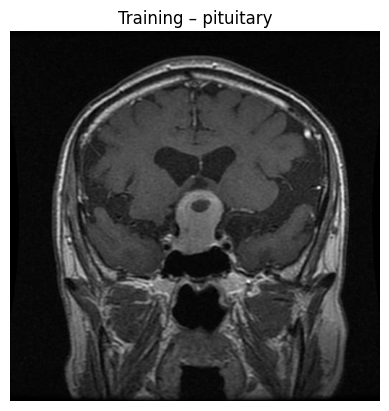

glioma: 1321 Bilder


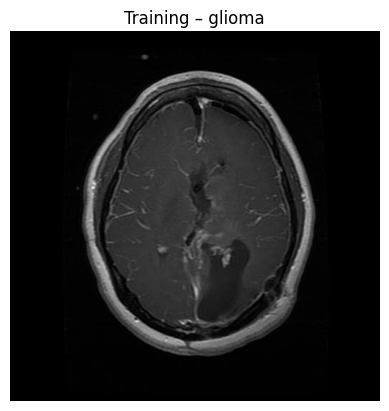

notumor: 1595 Bilder


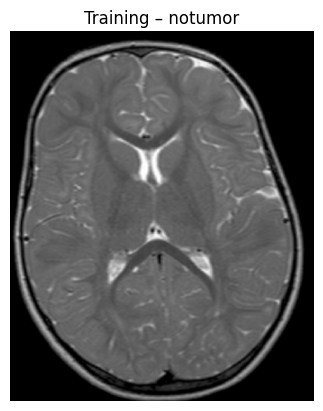

meningioma: 1339 Bilder


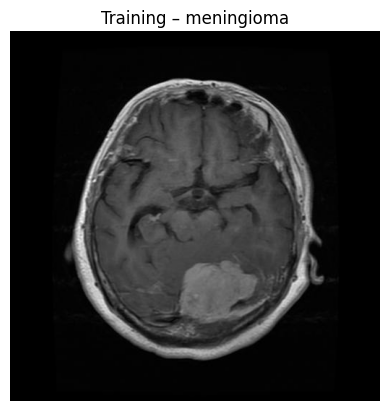

In [9]:
import random, cv2
import matplotlib.pyplot as plt
from pathlib import Path

train_dir = Path("../../data/brain-tumor-mri-dataset/Training")

classes = [p.name for p in train_dir.iterdir() if p.is_dir()]
print("Train-Klassen:", classes)

for cls in classes:
    cls_dir = train_dir / cls
    imgs = list(cls_dir.glob("*"))
    print(f"{cls}: {len(imgs)} Bilder")
    if imgs:
        img_path = random.choice(imgs)
        img = cv2.imread(str(img_path))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Training – {cls}")
        plt.axis("off")
        plt.show()


## 2. Preprocessing

In [10]:
from pathlib import Path
import cv2
import numpy as np
import shutil

# ----- settings -----
SRC_ROOT = Path("../../data/brain-tumor-mri-dataset")  # has Training/ and Testing/
DST_ROOT = Path("../../data/brain-tumor-mri-preproc")
TARGET_SIZE = (192, 192)   # (width, height) – change to e.g. (224, 224)
CLIP_PCT = (1, 99)         # robust intensity normalization (percentile clipping)
WRITE_EXT = ".png"

# clean/create dest
if DST_ROOT.exists():
    shutil.rmtree(DST_ROOT)
DST_ROOT.mkdir(parents=True, exist_ok=True)

def load_grayscale(path: Path) -> np.ndarray:
    """Read image as grayscale [H,W] float32 in range [0, 255]."""
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Could not read {path}")
    return img.astype(np.float32)

def downscale(img: np.ndarray, size=(192, 192)) -> np.ndarray:
    # AREA is best for downsampling scans
    return cv2.resize(img, size, interpolation=cv2.INTER_AREA)

def normalize(img: np.ndarray, clip_pct=(1, 99), mode="minmax") -> np.ndarray:
    """
    Robust per-image normalization.
    - clip to given percentiles (reduces outliers/noise)
    - then either min-max to [0,1] (default) or z-score (mode='zscore')
    """
    lo, hi = np.percentile(img, clip_pct)
    img = np.clip(img, lo, hi)
    if mode == "minmax":
        denom = (hi - lo) if hi > lo else 1.0
        img = (img - lo) / denom
    elif mode == "zscore":
        mu, sigma = img.mean(), img.std()
        img = (img - mu) / (sigma + 1e-8)
        # bring to [0,1] for saving (optional)
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    else:
        raise ValueError("mode must be 'minmax' or 'zscore'")
    return img

def process_one(src_path: Path, dst_path: Path):
    img = load_grayscale(src_path)               # [H,W], float32
    img = downscale(img, TARGET_SIZE)            # reduce resolution
    img = normalize(img, CLIP_PCT, "minmax")     # map to [0,1]
    # save as 8-bit PNG (keep file size small)
    to_save = (img * 255.0).round().astype(np.uint8)
    dst_path.parent.mkdir(parents=True, exist_ok=True)
    cv2.imwrite(str(dst_path.with_suffix(WRITE_EXT)), to_save)

# walk Training/ and Testing/ keeping structure
valid_exts = {".png", ".jpg", ".jpeg", ".bmp"}
for split in ["Training", "Testing"]:
    for cls_dir in (SRC_ROOT / split).iterdir():
        if not cls_dir.is_dir(): 
            continue
        for f in cls_dir.iterdir():
            if f.suffix.lower() in valid_exts:
                rel = f.relative_to(SRC_ROOT)                       # e.g. Training/glioma/img1.jpg
                out = DST_ROOT / rel                                # same structure
                process_one(f, out)

print("✅ Preprocessing done.\nSource:", SRC_ROOT, "\nOutput :", DST_ROOT)

✅ Preprocessing done.
Source: ../../data/brain-tumor-mri-dataset 
Output : ../../data/brain-tumor-mri-preproc


In [11]:
# --- (optional) small robustness tweaks ---
valid_exts = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}

def process_one(src_path: Path, dst_path: Path):
    img = load_grayscale(src_path)                     # [H,W], float32 in [0,255]
    img = downscale(img, TARGET_SIZE)                  # reduce resolution
    img = normalize(img, CLIP_PCT, "minmax")           # -> [0,1]
    # save as 8-bit PNG
    to_save = (img * 255.0).round().astype(np.uint8)
    dst_path = dst_path.with_suffix(WRITE_EXT)         # force .png
    dst_path.parent.mkdir(parents=True, exist_ok=True)
    ok = cv2.imwrite(str(dst_path), to_save)
    if not ok:
        raise IOError(f"Failed to write {dst_path}")

🔎 Visual check — TRAIN:


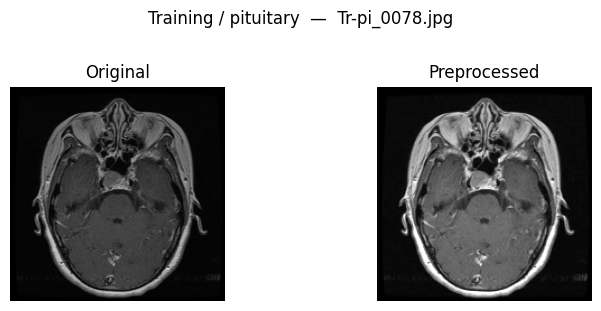

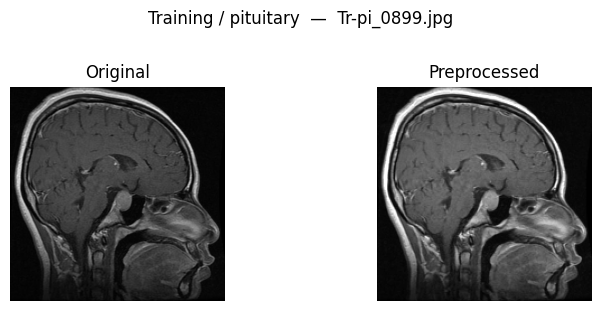

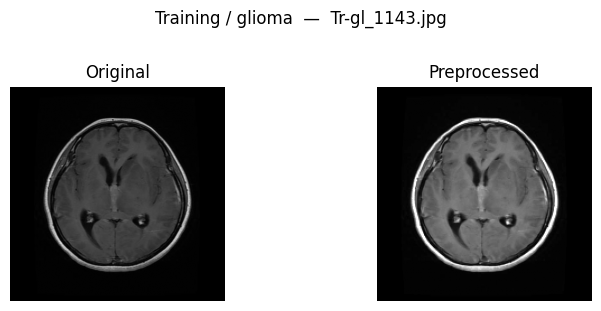

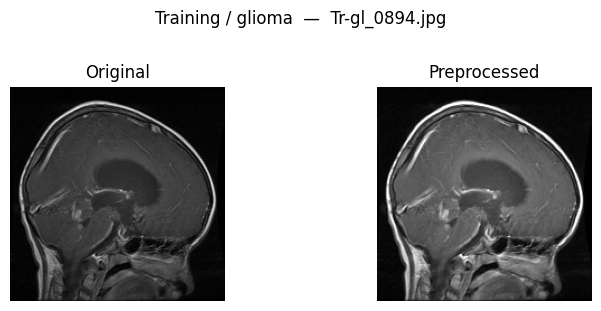

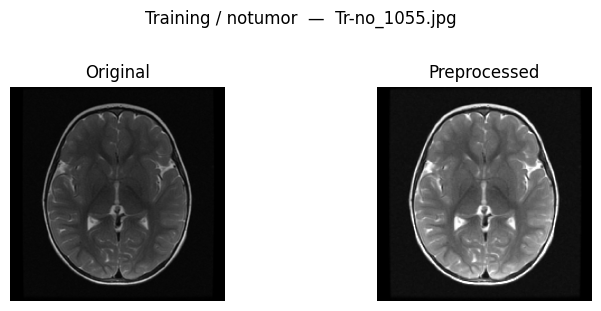

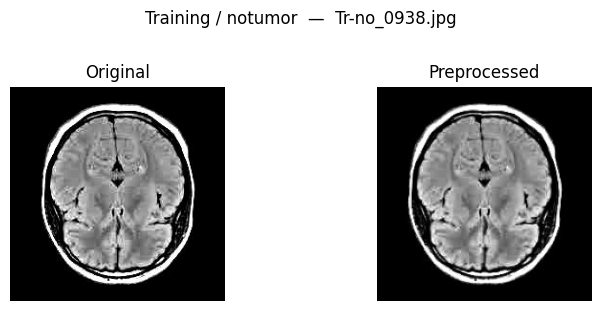

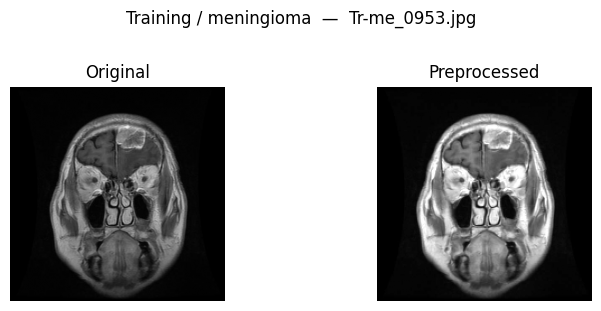

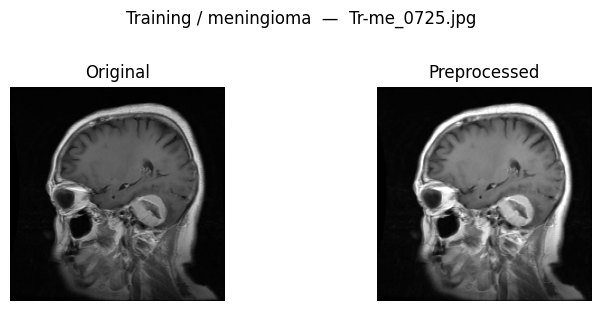

🔎 Visual check — TEST:


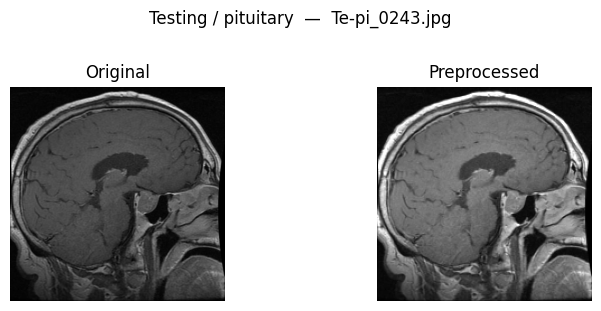

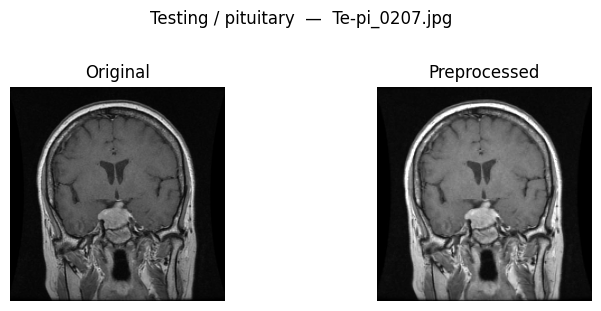

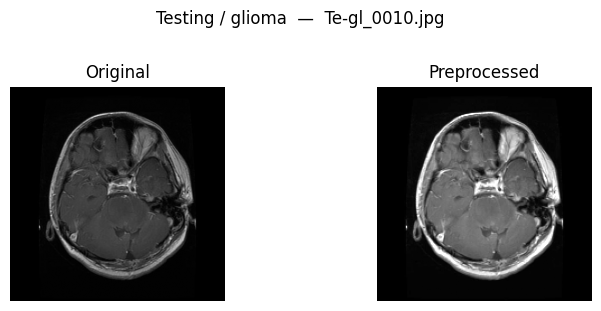

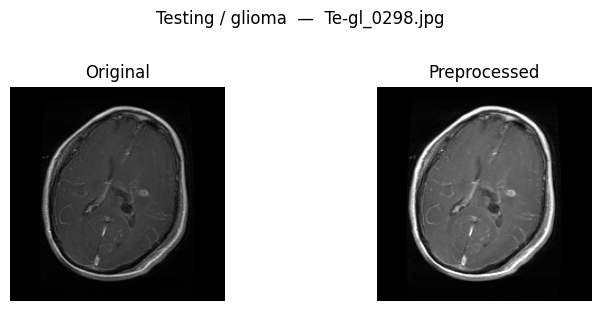

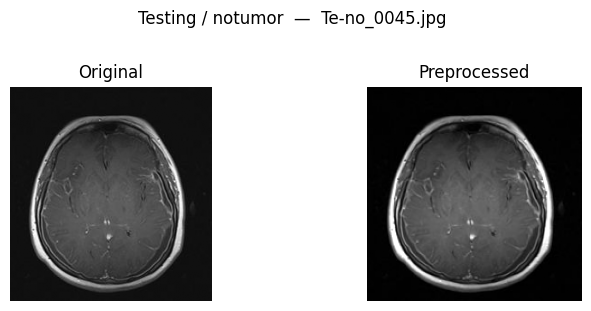

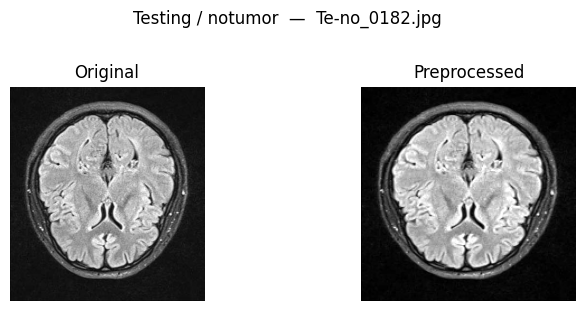

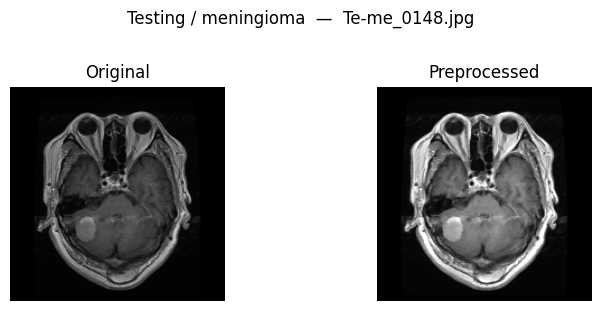

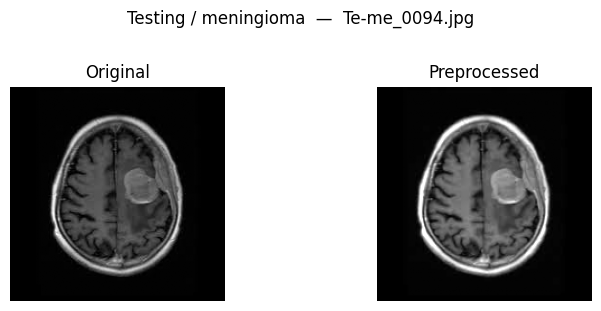

In [12]:
import random
import matplotlib.pyplot as plt

SRC_ROOT = Path("../../data/brain-tumor-mri-dataset")
DST_ROOT = Path("../../data/brain-tumor-mri-preproc")
valid_exts = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}

def show_before_after(split: str, n_per_class: int = 2):
    """
    For each class in {split}, pick up to n images and show
    original vs. preprocessed side-by-side.
    """
    split_src = SRC_ROOT / split
    classes = [d for d in split_src.iterdir() if d.is_dir()]
    if not classes:
        print(f"No classes found under {split_src}")
        return

    for cls_dir in classes:
        files = [f for f in cls_dir.iterdir() if f.suffix.lower() in valid_exts]
        if not files:
            print(f"(skip) no images in {cls_dir}")
            continue

        picks = random.sample(files, k=min(n_per_class, len(files)))
        for src in picks:
            # compute matching preprocessed path (same relative path, .png)
            rel = src.relative_to(SRC_ROOT)                        # e.g. Training/glioma/img123.jpg
            dst = (DST_ROOT / rel).with_suffix(".png")             # -> .../Training/glioma/img123.png

            # read both (grayscale)
            orig = cv2.imread(str(src), cv2.IMREAD_GRAYSCALE)
            proc = cv2.imread(str(dst), cv2.IMREAD_GRAYSCALE)

            if orig is None:
                print(f"(warn) cannot read original: {src}")
                continue
            if proc is None:
                print(f"(warn) cannot read processed: {dst}")
                continue

            # plot
            plt.figure(figsize=(8, 3))
            plt.suptitle(f"{split} / {cls_dir.name}  —  {src.name}", y=1.02)
            plt.subplot(1, 2, 1)
            plt.imshow(orig, cmap="gray")
            plt.title("Original")
            plt.axis("off")

            plt.subplot(1, 2, 2)
            plt.imshow(proc, cmap="gray")
            plt.title("Preprocessed")
            plt.axis("off")
            plt.tight_layout()
            plt.show()

print("🔎 Visual check — TRAIN:")
show_before_after("Training", n_per_class=2)

print("🔎 Visual check — TEST:")
show_before_after("Testing", n_per_class=2)

## 3. First CNN as Baseline

In [13]:
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path

# --- 1️⃣ Define directories ---
train_dir = Path("../../data/brain-tumor-mri-preproc/Training")

# --- 2️⃣ Dataset setup ---
IMG_SIZE = (192, 192)
BATCH_SIZE = 32
SEED = 1337
VAL_SPLIT = 0.2

train_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=VAL_SPLIT,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
)

val_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=VAL_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
)

print("Classes:", train_ds.class_names)

# --- 3️⃣ Define CNN model ---
inputs = keras.Input(shape=IMG_SIZE + (1,))  # (192,192,1)
x = layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
x = layers.MaxPool2D()(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)  # fully-connected layer
outputs = layers.Dense(len(train_ds.class_names), activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.summary()

# --- 4️⃣ Compile & train ---
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 192, 192, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 192, 192, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 96, 96, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     9,437,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,530,500 (36.36 MB)

 Trainable params: 9,530,500 (36.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 57s 383ms/step - accuracy: 0.6544 - loss: 28.3582 - val_accuracy: 0.8958 - val_loss: 0.3248
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 56s 391ms/step - accuracy: 0.9037 - loss: 0.2731 - val_accuracy: 0.9072 - val_loss: 0.2733
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 61s 424ms/step - accuracy: 0.9416 - loss: 0.1568 - val_accuracy: 0.9194 - val_loss: 0.2470
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 66s 464ms/step - accuracy: 0.9693 - loss: 0.0938 - val_accuracy: 0.9203 - val_loss: 0.2614
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 66s 460ms/step - accuracy: 0.9784 - loss: 0.0591 - val_accuracy: 0.9361 - val_loss: 0.2741
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 67s 467ms/step - accuracy: 0.9885 - loss: 0.0332 - val_accuracy: 0.9194 - val_loss: 0.3380
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 64s 449ms/step - accuracy: 0.9817 - loss: 0.0615 - val_accuracy: 0.8923 - val_loss: 0.3946
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 66s 459ms/step - accuracy: 0.9901 - loss: 

In [14]:
from tensorflow import keras
from pathlib import Path

# Pfad zum Test-Set (dein preprocessed Datensatz)
test_dir = Path("../../data/brain-tumor-mri-preproc/Testing")

IMG_SIZE = (192, 192)
BATCH_SIZE = 32

# Test-Dataset laden (keine Validation-Split nötig)
test_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    shuffle=False   # wichtig! Labels bleiben in richtiger Reihenfolge
)

# Evaluate
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Found 1311 files belonging to 4 classes.
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.9193 - loss: 0.3481
✅ Test Accuracy: 0.9306
Test Loss: 0.2713


## 4. Improved CNN

In [15]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers

IMG_SIZE = (192, 192)   # same as before
NUM_CLASSES = len(train_ds.class_names)
L2 = 1e-4               # weight decay strength (try 1e-5 … 5e-4)

# --- Data augmentation ---
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
], name="aug")

def conv_block(x, filters, l2=L2, sd_rate=0.1):
    x = layers.Conv2D(filters, 3, padding="same", use_bias=False,
                      kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, 3, padding="same", use_bias=False,
                      kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.MaxPool2D()(x)
    x = layers.SpatialDropout2D(sd_rate)(x)
    return x

# --- Model ---
inputs = keras.Input(shape=IMG_SIZE + (1,))              # grayscale
x = data_augmentation(inputs)                            # aug happens only in training
x = conv_block(x, 32)
x = conv_block(x, 64)
x = conv_block(x, 128)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu",
                 kernel_regularizer=regularizers.l2(L2))(x)
x = layers.Dropout(0.5)(x)                               # regularize the head
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.summary()

# --- Compile ---
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# --- Callbacks: LR schedule + EarlyStopping ---
cbs = [
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5,
                                      patience=2, min_lr=1e-6, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5,
                                  restore_best_weights=True, verbose=1),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=cbs,
)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 192, 192, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aug (Sequential)                │ (None, 192, 192, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 192, 192, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 192, 192, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 192, 192, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 192, 192, 32)   │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 192, 192, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 192, 192, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d               │ (None, 96, 96, 32)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 96, 96, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 96, 96, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 96, 96, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 96, 96, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 96, 96, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 96, 96, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_1             │ (None, 48, 48, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 48, 48, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 48, 48, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 48, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 304,804 (1.16 MB)

 Trainable params: 303,908 (1.16 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 340s 2s/step - accuracy: 0.5101 - loss: 1.1708 - val_accuracy: 0.2671 - val_loss: 5.5357 - learning_rate: 0.0010
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 325s 2s/step - accuracy: 0.6343 - loss: 0.9108 - val_accuracy: 0.3065 - val_loss: 2.2498 - learning_rate: 0.0010
Epoch 3/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.6484 - loss: 0.8611 - val_accuracy: 0.3660 - val_loss: 2.2611 - learning_rate: 0.0010
Epoch 4/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.6687 - loss: 0.8420 - val_accuracy: 0.7207 - val_loss: 0.7709 - learning_rate: 0.0010
Epoch 5/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 293s 2s/step - accuracy: 0.6960 - loss: 0.7826 - val_accuracy: 0.5989 - val_loss: 1.0277 - learning_rate: 0.0010
Epoch 6/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 755s 2s/step - accuracy: 0.6915 - loss: 0.7557 - val_accuracy: 0.8039 - val_loss: 0.5678 - learning_rate: 5.0000e-04
Epoch 8/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - accuracy: 0.7236 - loss